In [ ]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image
import pandas as pd


BASE_DIR = Path("../data/raw/DENTEX")

ANNOTATION_FILE = BASE_DIR / "validation_triple.json"

IMAGE_DIR = BASE_DIR / "val" / "validation_data" / "quadrant_enumeration_disease" / "xrays"

print(f"📂 Veri Kök Dizini: {BASE_DIR}")

📂 Veri Kök Dizini: ../data/raw/DENTEX
📄 Anotasyon Dosyası: ../data/raw/DENTEX/validation_triple.json
🖼️ Resim Klasörü: ../data/raw/DENTEX/val/validation_data/quadrant_enumeration_disease/xrays
✅ Dosya yolları doğrulandı. Analize başlanıyor...


In [3]:
with open(ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

# Kategori haritalarını (ID -> İsim) oluştur
cat_map_1 = {c['id']: c['name'] for c in coco_data['categories_1']} # Quadrant
cat_map_2 = {c['id']: c['name'] for c in coco_data['categories_2']} # Tooth Number
cat_map_3 = {c['id']: c['name'] for c in coco_data['categories_3']} # Diagnosis (Hastalık)

print("\n--- SINIFLAR ---")
print(f"Bölgeler: {cat_map_1}")
print(f"Diş Numaraları: {cat_map_2}")
print(f"Hastalıklar: {cat_map_3}")


--- SINIFLAR ---
Bölgeler: {0: '1', 1: '2', 2: '3', 3: '4'}
Diş Numaraları: {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8'}
Hastalıklar: {0: 'Impacted', 1: 'Caries', 2: 'Periapical Lesion', 3: 'Deep Caries'}



Görselleştiriliyor: val_16.png
Toplam Tespit Sayısı: 6


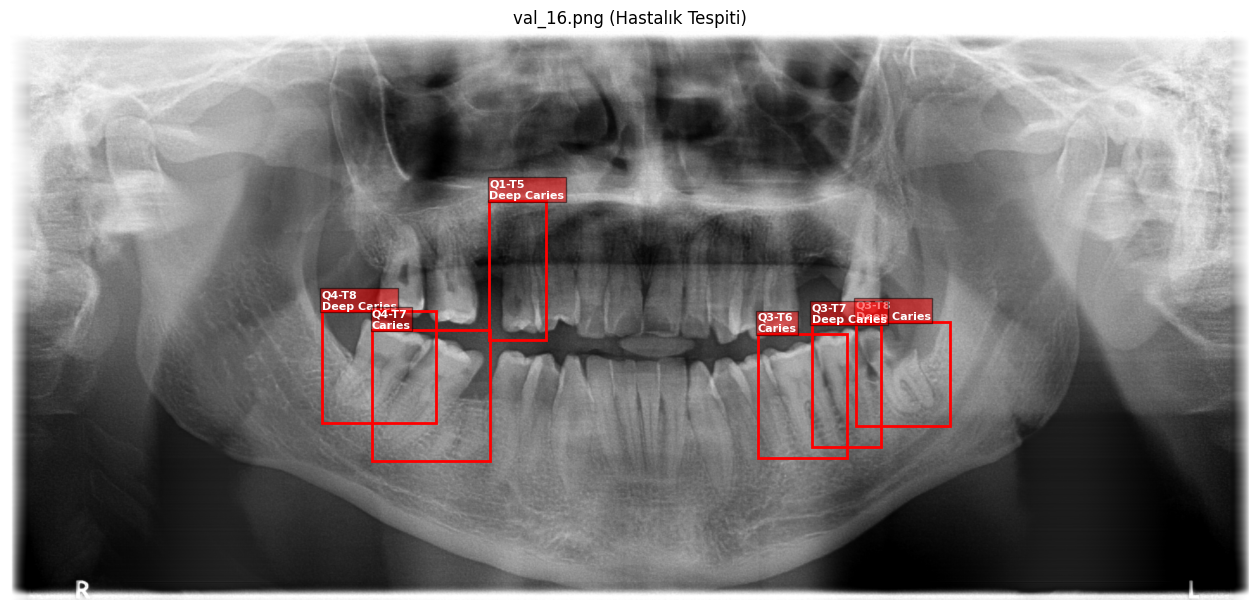

In [ ]:
def visualize_dentex_sample():
    # Rastgele bir resim seç
    img_info = random.choice(coco_data['images'])
    file_name = img_info['file_name']
    img_id = img_info['id']
    
    img_path = IMAGE_DIR / file_name
    
    # Resmi yüklemeyi dene
    try:
        image = Image.open(img_path)
    except FileNotFoundError:
        print(f"❌ Resim dosyası diskte bulunamadı: {img_path}")
        return

    # Anotasyonları bul
    anns = [a for a in coco_data['annotations'] if a['image_id'] == img_id]
    
    plt.figure(figsize=(16, 10))
    plt.imshow(image, cmap='gray')
    ax = plt.gca()
    
    print(f"\nGörselleştiriliyor: {file_name}")
    print(f"Toplam Tespit Sayısı: {len(anns)}")
    
    for ann in anns:
        bbox = ann['bbox'] # [x, y, w, h]
        
        # Etiket bilgilerini çek
        quad = cat_map_1.get(ann['category_id_1'], '?')
        tooth = cat_map_2.get(ann['category_id_2'], '?')
        diag = cat_map_3.get(ann['category_id_3'], '?')
        
        label_text = f"Q{quad}-T{tooth}\n{diag}"
        
        # Çizim
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(
            bbox[0], bbox[1]-5, label_text, 
            color='white', fontsize=8, weight='bold', 
            bbox=dict(facecolor='red', alpha=0.5, pad=1)
        )
        
    plt.axis('off')
    plt.title(f"{file_name} (Hastalık Tespiti)")
    plt.show()

# Fonksiyonu çalıştır
visualize_dentex_sample()


--- Veri Setindeki Hastalık Dağılımı ---
            Hastalık  Adet
1             Caries   101
0           Impacted    40
3        Deep Caries    32
2  Periapical Lesion     9


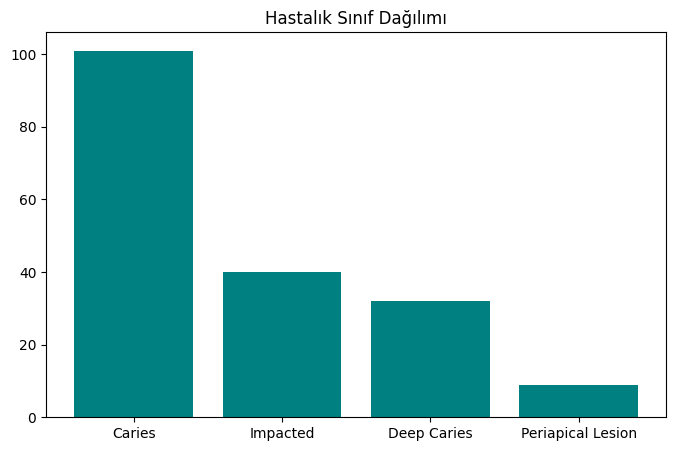

In [5]:
diag_counts = {}
for ann in coco_data['annotations']:
    d_name = cat_map_3.get(ann['category_id_3'], 'Unknown')
    diag_counts[d_name] = diag_counts.get(d_name, 0) + 1

df = pd.DataFrame(list(diag_counts.items()), columns=['Hastalık', 'Adet']).sort_values('Adet', ascending=False)
print("\n--- Veri Setindeki Hastalık Dağılımı ---")
print(df)

plt.figure(figsize=(8, 5))
plt.bar(df['Hastalık'], df['Adet'], color='teal')
plt.title("Hastalık Sınıf Dağılımı")
plt.show()